In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops

from PIL import Image
from pdf2image import convert_from_bytes, convert_from_path

In [2]:
def show_image(img):
    fig,ax = plt.subplots(figsize=(10,6)) 
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [3]:
def fileToImages(file_name):
    with open(file_name,'rb') as file:
        pdf_test=file.read()
        images = convert_from_bytes(pdf_test)
        return images

In [24]:
def extract_sign(img,outlier_weight = 3,outlier_bias = 100,amplifier = 10,area_size = 10):
    condition = img > img.mean()
    labels = measure.label(condition,background = 1)
    total_pixels = 0
    nb_region = 0
    average = 0.0
    for region in regionprops(labels):
        if(region.area > area_size):
            total_pixels += region.area
            nb_region += 1
    average = (total_pixels/nb_region)
    small_size_outlier = average * outlier_weight + outlier_bias
    big_size_outlier = small_size_outlier * amplifier
    pre_version = morphology.remove_small_objects(labels,small_size_outlier)
    component_sizes = np.bincount(pre_version.ravel())
    too_small = component_sizes > (big_size_outlier)
    too_small_mask = too_small[pre_version]
    pre_version[too_small_mask] = 0

    labeled_mask = np.full(pre_version.shape,255,dtype='uint8')
    labeled_mask = labeled_mask * (pre_version == 0)
    return labeled_mask

TypeError: Image data of dtype object cannot be converted to float

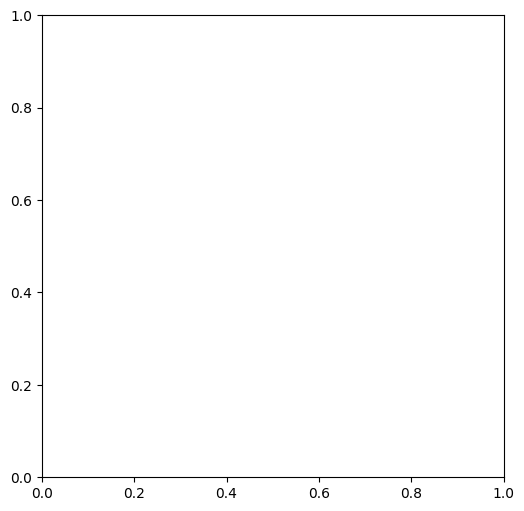

In [25]:
image = cv2.imread('Signature1.jpg')
show_image(image)

In [26]:
frame_HSV = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
frame_threshold = cv2.inRange(frame_HSV,(0,0,250),(255,255,255))
show_image(frame_threshold)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


C:\Users\SINCHAN BASU\AppData\Local\Temp\ipykernel_16748\1818955390.py:14: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pre_version = morphology.remove_small_objects(labels,small_size_outlier)


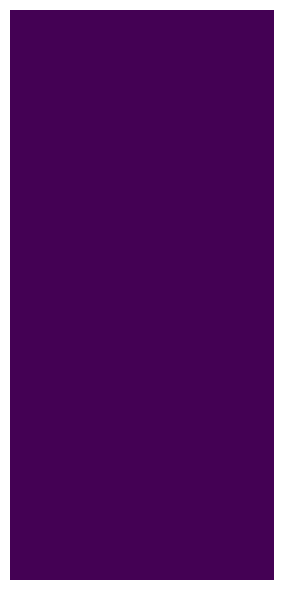

In [8]:
preview = extract_sign(frame_threshold)
show_image(preview)
plt.imsave('signed_image.jpg', preview)

In [9]:
cnts = cv2.findContours(preview, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = cnts[0] if len(cnts) == 2 else cnts[1]


[]


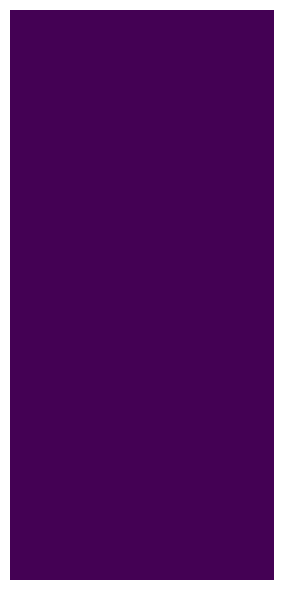

In [11]:
boxes = []
copy_img = preview.copy()
for c in cnt:
    (x, y, w, h) = cv2.boundingRect(c)
    if h * w > 10000 and h < copy_img.shape[0] and w < copy_img.shape[1]:
        cv2.rectangle(copy_img,(x,y),(x+w,y+h),(155,155,0),1)
        boxes.append([x, y, w, h])
print(boxes)
show_image(copy_img)
plt.imsave('signed_image_boxed.jpeg', copy_img)

In [12]:
np_boxes = np.array(boxes)

In [13]:
area_size = list(map(lambda box: box[2] * box[3], np_boxes))
area_size = np.array(area_size)
area_dec_order = area_size.argsort()[::-1]
area_dec_order

array([], dtype=int64)

In [14]:
sorted_boxes = np_boxes[area_dec_order]

In [16]:
def is_intersected(box_a, box_b) -> bool:
    [x_a, y_a, w_a, h_a] = box_a    
    [x_b, y_b, w_b, h_b] = box_b
    
    if y_a > y_b + h_b: return False
    if y_a + h_a < y_b: return False
    if x_a > x_b + w_b: return False
    if x_a + w_a < x_b: return False
    return True

In [17]:
regions = {}
for i, box in enumerate(sorted_boxes):
    if len(regions) == 0:
        regions[0] = box
    else:
        is_merged = False
        for key, region in regions.items():
            if is_intersected(region, box) == True:
                new_region = merge_boxes(region, box)
                regions[key] = new_region
                is_merged = True
                break
        if is_merged == False:
            key = len(regions)
            regions[key] = box

In [19]:
regions

{}

In [20]:
def draw_regions(img, regions):
    cwd = os.getcwd()
    
    for key, region in regions.items():
        copy_img = Image.fromarray(img)
        [x, y, w, h] = region
        
        crop = copy_img.crop((x, y, x + w, y + h))
        crop.save(cwd + '/data/output/signed_image_region_{}.jpeg'.format(key), 'JPEG')

In [21]:
draw_regions(preview, regions)